# Assignment 1

This assignment requires you to implement a K-Nearest Neighbors classifier and test it using the `column_2C_weka` data from the **Vertebral Column dataset**, which you can download from [this page on the UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/212/vertebral+column). It walks you through the steps of a typical machine learning workflow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

## Fetching and preparing the data

* **(5 points)** Read the `column_2C_weka` data of the above Vertebral Column dataset into a Pandas dataframe. The dataset contains six input features plus a binary target column(the output).

In [2]:
vert = pd.read_csv('vertebral+column/column_2C.DAT', sep=' ', header=None)
vert.columns = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'output']
vert

,feat1,feat2,feat3,feat4,feat5,feat6,output
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


* **(5 points)** Re-code the values of the output column to 0 for “Normal” and 1 for “Abnormal”.

In [3]:
vert['output'] = vert['output'].map({'AB': 1, 'NO': 0})
vert

,feat1,feat2,feat3,feat4,feat5,feat6,output
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,0
306,53.94,20.72,29.22,33.22,114.37,-0.42,0
307,61.45,22.69,46.17,38.75,125.67,-2.71,0
308,45.25,8.69,41.58,36.56,118.55,0.21,0


* **(5 points)** Perform feature scaling by normalizing the values of each feature column. We use feature scaling to make sure that features with larger values do not render features with small values insignificant. Use the following formula for normalization: $$ x_{new}  = \frac{x - x_{min}}{x_{max} - x_{min}}$$

In [4]:
vert[['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6']] = vert[['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6']].apply(lambda iterr: (iterr - iterr.min()) / (iterr.max() - iterr.min()))

* **(5 points)** Split the dataset into two sets: 25% for testing and the rest for training.

In [5]:
#shuffle
np.random.seed(42)
vert = vert.sample(len(vert))

#get split idx
split_idx = int(.75 * len(vert))

#split
training, testing = vert.iloc[:split_idx,:], vert.iloc[split_idx:,:]

print(training.shape)
print(testing.shape)

(232, 7)
(78, 7)


## Implementing the classifier

* **(30 points)** Define a class named `KNearestNeighborClassifier` that generalizes the NearestNeighborClassifier of the `05.nearest_neighbors.ipynb` handout to `k` neighbors instead of just 1. The class must define a `fit()` and `predict()` methods just like `NearestNeighborClassifier` does.

In [6]:
class KNearestNeighborClassifier:
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        return self
    
    def predict(self, X_unseen, k):
        if X_unseen.ndim == 1:
            distances = np.sqrt(np.sum((self.X - X_unseen)**2, axis=1))
            #sort 'k' values
            k_min_idx = distances.argpartition(k)
            #retrieve 'k' smallest values' idxs and get respective values
            k_min_vals = self.y[k_min_idx[:k]]
            #get bincounts
            return np.bincount(k_min_vals).argmax()
        else:
            return np.array([self.predict(ex, k) for ex in X_unseen])

## Hyperparameter tuning using 10-fold cross-validation
* **(20 points)** Define a function that implements **10-fold cross-validation**. See the lecture notes for how such a function works. Use $1 - accuracy$ as an error measure. The learner in this case is your `KNearestNeighborClassifier` class and $k$ (the number of neighbors is the hyperparameter.

In [7]:
def fold10_cv(X, y, model, k_neighbors, cv_fold=10):
    batch_size = len(X) // cv_fold
    err = 0
    for i in range(10):
        test_start_idx = i * batch_size
        test_end_idx = (i + 1) * batch_size
        
        mask = np.ones(len(X), dtype=bool)
        mask[[range(test_start_idx, test_end_idx)]] = False
        
        X_val, y_val = X[~mask], y[~mask]
        X_train, y_train = X[mask], y[mask]
        
        nn = model().fit(X_train, y_train)
        y_predictions = nn.predict(X_val, k_neighbors)
        cm = np.array(confusion_matrix(y_val, y_predictions))
        acc = np.diag(cm).sum() / np.sum(cm)
        err += 1 - acc
    return err / cv_fold        

* **(10 points)** Use the above **10-fold cross-validation** function to plot the values of `k` (1 to 20) against their cross-validation errors. Using this plot, what is the best value for `k`?

In [8]:
import matplotlib.ticker as mticker

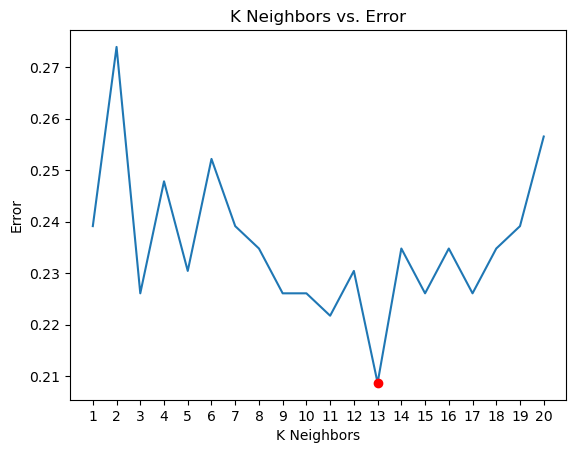

In [9]:
err = []
X_train = training.iloc[:,:-1].values
y_train = training.iloc[:,-1].values

for k_neighbor in range(1, 21):
    err.append(fold10_cv(X_train, y_train, KNearestNeighborClassifier, k_neighbor, 10))

min_err_idx = np.argmin(err)
    
fig, ax = plt.subplots()
ax.plot(range(1,21), err)
ax.plot(min_err_idx+1, err[min_err_idx], 'ro')
ax.set_title('K Neighbors vs. Error')
ax.set_xlabel('K Neighbors')
ax.set_ylabel('Error')
ax.set_xticks(range(1,21))

## Testing the classifier
* **(10 points)** Train a model of the above `KNearestNeighborClassifier` with the “found-out” best `k` value. Test the trained model using the testing set. Show its confusion matrix and accuracy.

In [10]:
X_train = training.iloc[:,:-1].values
y_train = training.iloc[:,-1].values

X_test = testing.iloc[:,:-1].values
y_test = testing.iloc[:,-1].values

best_nn = KNearestNeighborClassifier().fit(X_train, y_train)
y_pred = best_nn.predict(X_test, k=min_err_idx+1)

cm = confusion_matrix(y_test, y_pred)
print(f'''
confusion matrix w/k={min_err_idx+1}:
{cm}

accuracy: {np.diag(cm).sum() / cm.sum()}
''')


confusion matrix w/k=13:
[[21  7]
 [ 8 42]]

accuracy: 0.8076923076923077



* **(10 points)** Plot a point corresponding to the above confusion matrix on the ROC (Receiver Operating Characteristic) plot; no curve, just a point. Make sure to also plot the line from (0,0) to (1,1). 

sens: 0.84
spec: 0.75


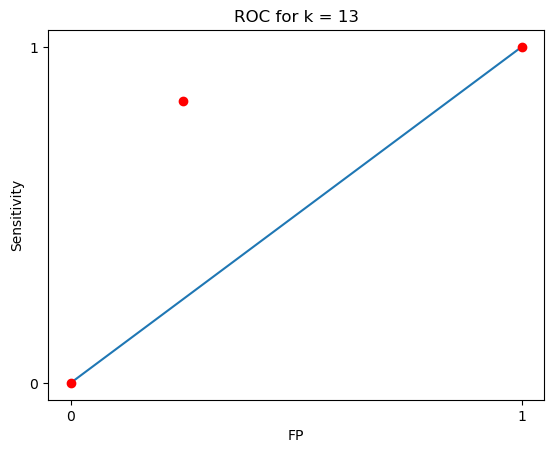

In [11]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()
print('sens:', tp / (tp + fn))
print('spec:', tn / (fp + tn))

fig, ax = plt.subplots()
ax.plot([0,1])
ax.plot(fpr, tpr,'ro') 
ax.set_title(f'ROC for k = {min_err_idx+1}')
ax.set_xlabel('FP')
ax.set_ylabel('Sensitivity')
ax.set_yticks(range(2))
ax.set_xticks(range(2))